In [2]:
%load_ext autoreload

import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib
from tqdm import tqdm

import numpy as onp
from jax.config import config
# config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot
from jax import tree_util

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm
from models import Optimizer
from collections import namedtuple
from typing import Mapping
from models import GradientLearner, SDLearner, Patience, KernelLearner, ScoreLearner

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from models import KernelGradient, KernelizedScoreMatcher

In [4]:
# Setup and samples
target = distributions.GaussianMixture([-3, 3], [1, 1], [1/3, 2/3])
proposal = distributions.Gaussian(-5, 1)
setup = distributions.Setup(target, proposal)
n_samples = 400
training_samples = proposal.sample(n_samples)

# Models
# Score learner
score_gradient = KernelizedScoreMatcher(target, key, lambda_reg=1/2)
learned_score = score_gradient.get_score(training_samples)
learned_score_scalar = utils.reshape_input(learned_score) # accept scalar input
true_score = utils.mul(grad(proposal.logpdf), 1/(2*score_gradient.lambda_reg))

# SVGD learner
svgd_gradient = KernelGradient(target, key, lambda_reg=1/2)

# How good is the score approximation?

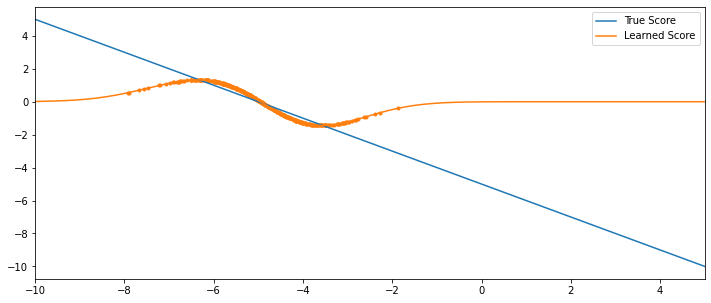

In [9]:
fig, ax = plt.subplots(figsize=[12, 5])
xlim = (-10, 5)
ax.set(xlim=xlim)
samples = proposal.sample(n_samples)

# plot the learned gradient
grid = np.linspace(-15, 15, 100)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()
full_grid = np.expand_dims(full_grid, axis=1)

plot.plot_fun(true_score, lims=xlim, ax=ax, label="True Score")
plot.plot_fun(learned_score_scalar, lims=xlim, ax=ax, label="Learned Score")
ax.scatter(samples, vmap(learned_score)(samples), color="tab:orange", marker=".")
ax.legend()

# How good is the KL div approximation?

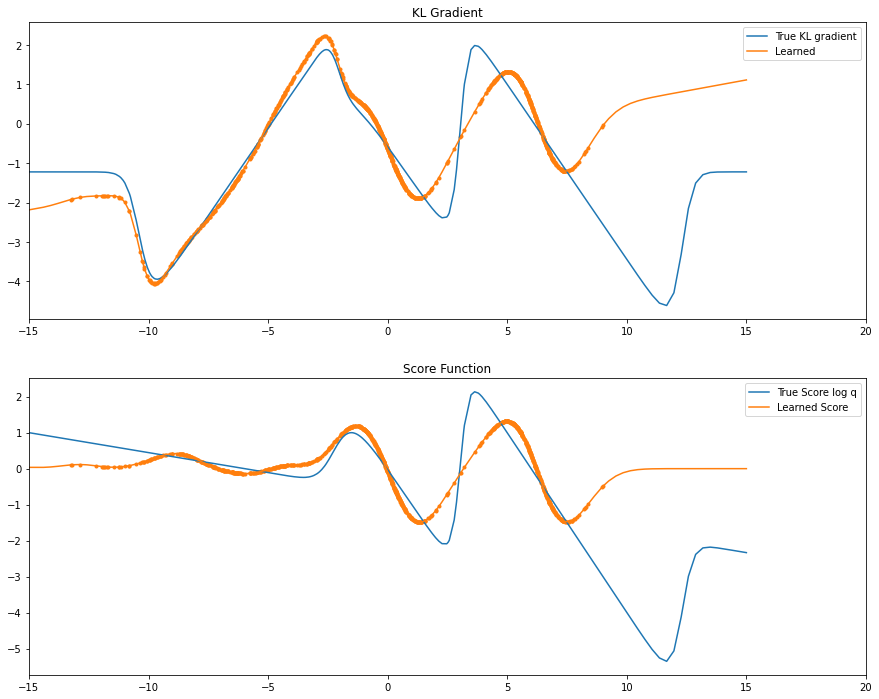

In [4]:
samples = proposal.sample(1000)
samples = np.sort(samples, axis=0)
xlim = (-15, 20)

# plot the learned gradient
grid = np.linspace(-15, 15, 100)
full_grid = np.concatenate([grid, np.squeeze(samples)]).sort()
full_grid = np.expand_dims(full_grid, axis=1)

fig, axs = plt.subplots(2, figsize=[15, 12])
ax = axs[0]
ax.plot(full_grid, vmap(opt_g)(full_grid), label="True KL gradient")
ax.plot(full_grid, vmap(v)(full_grid), label="Learned")
ax.scatter(samples, vmap(v)(samples), marker=".", color="tab:orange")
# ax.set_ylim((-10,3))
ax.set_xlim(xlim)
ax.set_title("KL Gradient")
ax.legend()

ax = axs[1]
ax.plot(full_grid, vmap(true_score)(full_grid), label="True Score log q")
ax.plot(full_grid, vmap(learned_score)(full_grid), label="Learned Score")
ax.scatter(samples, vmap(learned_score)(samples), marker=".", color="tab:orange")
# ax.set_ylim((-10,3))
ax.set_xlim(xlim)
ax.set_title("Score Function")
ax.legend()

In [5]:
utils.l2_norm(samples, learned_score)

AttributeError: module 'utils' has no attribute 'l2_norm'

In [ ]:
utils.l2_norm(samples, utils.mul(true_score, 1/(2*gradient.lambda_reg)))